# Self-supervised learning project
Comparing self-supervised ResNet with SimCLR to normal ResNet

## Universal settings and helpers

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torchvision
from PIL import Image
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize

from lightly.data import LightlyDataset
from lightly.transforms import SimCLRTransform, utils

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if device == "cuda":
    # Should increase performance on GPUs with tensor cores 
    # Not sure if it is supported on all GPUs; consider disabling
    torch.set_float32_matmul_precision('medium') 

Using device: cuda


In [4]:
num_workers = 32 # I have 32 CPU threads
input_size = 32 # CIFAR10 images are 32x32

In [5]:
seed = 1
pl.seed_everything(seed)

Seed set to 1


1

This function prints some metrics we can use to compare the different classifiers.

In [6]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

def eval_classifier(classifier):
    classifier.to(device)  

    classifier.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_classifier_dl:
            images, labels = images.to(device), labels.to(device)
            outputs = classifier(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    conf_matrix = confusion_matrix(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds)

    print("Confusion Matrix:\n", conf_matrix)
    print("\nClassification Report:\n", class_report)

## Define the classifier

The same classifier is used for the SimCLR model and the pretrained ResNet model.

In [7]:
from pytorch_lightning.callbacks import EarlyStopping
from lightly.models.utils import deactivate_requires_grad

class Classifier(pl.LightningModule):
    def __init__(self, backbone, num_ftrs):
        super().__init__()
        self.backbone = backbone

        # freeze the backbone
        deactivate_requires_grad(backbone)

        self.fc = nn.Linear(num_ftrs, 10) # 10 is the number of output classes

        self.criterion = nn.CrossEntropyLoss()
        self.validation_step_outputs = []

    def forward(self, x):
        y_hat = self.backbone(x).flatten(start_dim=1)
        y_hat = self.fc(y_hat)
        return y_hat

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.criterion(y_hat, y)
        self.log("train_loss_fc", loss)
        return loss

    def on_train_epoch_end(self):
        self.custom_histogram_weights()

    def custom_histogram_weights(self):
        for name, params in self.named_parameters():
            self.logger.experiment.add_histogram(name, params, self.current_epoch)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        y_hat = torch.nn.functional.softmax(y_hat, dim=1)

        loss = self.criterion(y_hat, y)
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)

        _, predicted = torch.max(y_hat, 1)
        num = predicted.shape[0]
        correct = (predicted == y).float().sum()
        self.validation_step_outputs.append((num, correct))
        return num, correct

    def on_validation_epoch_end(self):
        if self.validation_step_outputs:
            total_num = 0
            total_correct = 0
            for num, correct in self.validation_step_outputs:
                total_num += num
                total_correct += correct
            acc = total_correct / total_num
            self.log("val_acc", acc, on_epoch=True, prog_bar=True)
            self.validation_step_outputs.clear()

    def configure_optimizers(self):
        optim = torch.optim.SGD(self.fc.parameters(), lr=2e-2)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, max_epochs)
        return [optim], [scheduler]

## Load classifier dataset

The same dataset is used to fine-tune the classifier using the SimCLR model and the pretrained ResNet model.

We use just 1% of the labeled CIFAR10 dataset (500 samples).

In [8]:
batch_size = 64

In [9]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import numpy as np

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_classifier_ds_full = torchvision.datasets.CIFAR10(
    root="datasets/cifar10",
    train=True,
    download=True,
    transform=transform
)

test_classifier_ds = torchvision.datasets.CIFAR10(
    root="datasets/cifar10",
    train=False,
    download=True,
    transform=transform
)

# Selecting 1% of the training data
num_train_samples = len(train_classifier_ds_full)
subset_size = int(0.01 * num_train_samples)
indices = np.random.choice(num_train_samples, subset_size, replace=False)
train_classifier_ds = Subset(train_classifier_ds_full, indices)

# DataLoaders
train_classifier_dl = DataLoader(
    train_classifier_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers
)

train_classifier_dl_full = DataLoader(
    train_classifier_ds_full,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers
)

test_classifier_dl = DataLoader(
    test_classifier_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers
)

Files already downloaded and verified
Files already downloaded and verified


## Pretraining ResNet with SimCLR

Some hyperparameters

In [9]:
simclr_batch_size = 4096 # Used by the original SimCLR (https://github.com/google-research/simclr?tab=readme-ov-file#pretraining)

### Load the training and testing data

In [10]:
transform = SimCLRTransform(input_size=input_size, vf_prob=0.5, rr_prob=0.5)

test_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((input_size, input_size)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=utils.IMAGENET_NORMALIZE["mean"],
            std=utils.IMAGENET_NORMALIZE["std"],
        ),
    ]
)

In [11]:
train_simclr_ds = torchvision.datasets.CIFAR10(
    "datasets/cifar10", download=True, transform=transform
)

test_simclr_ds = torchvision.datasets.CIFAR10(
    "datasets/cifar10", download=True, transform=test_transform
)

train_simclr_dl = torch.utils.data.DataLoader(
    train_simclr_ds,
    batch_size=simclr_batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
)

test_simclr_dl = torch.utils.data.DataLoader(
    test_simclr_ds,
    batch_size=simclr_batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
)

Files already downloaded and verified
Files already downloaded and verified


### Implement SimCLR model

In [12]:
from lightly.loss import NTXentLoss
from lightly.models.modules.heads import SimCLRProjectionHead

# Inspired by
# https://docs.lightly.ai/self-supervised-learning/tutorials/package/tutorial_simclr_clothing.html#create-the-simclr-model 
class SimCLRModel(pl.LightningModule):
    def __init__(self):
        super().__init__()

        # create a ResNet backbone and remove the classification head
        resnet = torchvision.models.resnet18()
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])

        hidden_dim = resnet.fc.in_features
        self.projection_head = SimCLRProjectionHead(hidden_dim, hidden_dim, 128)

        self.criterion = NTXentLoss()

    def forward(self, x):
        h = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(h)
        return z

    def training_step(self, batch, batch_idx):
        (x0, x1), _ = batch
        z0 = self.forward(x0)
        z1 = self.forward(x1)
        loss = self.criterion(z0, z1)
        self.log("train_loss_ssl", loss, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optim = torch.optim.SGD(
            self.parameters(), lr=6e-2, momentum=0.9, weight_decay=5e-4
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, max_epochs)
        return [optim], [scheduler]

Train the model

In [13]:
max_epochs = 1000

In [14]:
simclr_model = SimCLRModel()
trainer = pl.Trainer(max_epochs=max_epochs, devices=1, accelerator="gpu", log_every_n_steps=1)
trainer.fit(simclr_model, train_simclr_dl)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: /home/torstein/repos/school/tdt05/TDT05-Mini-Project/lightning_logs
2023-11-16 12:09:52.189022: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-16 12:09:52.391516: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, r

Epoch 2:  33%|███▎      | 4/12 [00:06<00:13,  0.60it/s, v_num=0, train_loss_ssl_step=8.700, train_loss_ssl_epoch=8.780] 

/home/torstein/anaconda3/envs/tdt05/lib/python3.11/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [ ]:
torch.save(simclr_model.state_dict(), "models/pretrained-simclr-1000.pt")

### Evaluate performance (qualitative)

The Lightly docs included some instructions on how to visualize the nearest neighbors of a couple of images, so let's take a look at that.

In [15]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

# Borrowed from
# https://docs.lightly.ai/self-supervised-learning/tutorials/package/tutorial_simclr_clothing.html#create-the-simclr-model 
def generate_embeddings(model, dataloader):
    """Generates representations for all images in the dataloader with the given model"""

    embeddings = []
    with torch.no_grad():
        for img, _ in dataloader:  # Only extract the images, ignore the labels
            img = img.to(model.device)
            emb = model.backbone(img).flatten(start_dim=1)
            embeddings.append(emb)

    embeddings = torch.cat(embeddings, 0)
    embeddings = normalize(embeddings)
    return embeddings

def plot_knn_examples(embeddings, images, n_neighbors=3, num_examples=6):
    """Plots multiple rows of random images with their nearest neighbors."""
    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(embeddings)
    distances, indices = nbrs.kneighbors(embeddings)

    samples_idx = np.random.choice(len(indices), size=num_examples, replace=False)

    for idx in samples_idx:
        fig = plt.figure(figsize=(15, 3))
        for plot_x_offset, neighbor_idx in enumerate(indices[idx]):
            ax = fig.add_subplot(1, n_neighbors, plot_x_offset + 1)
            plt.imshow(images[neighbor_idx])
            ax.set_title(f"d={distances[idx][plot_x_offset]:.3f}")
            plt.axis("off")

The CIFAR10 dataset is stored as binary files using pickle, so we need to unpickle them.

In [16]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def load_cifar10_batch(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def unpack_image(data):
    """ Convert a CIFAR-10 flattened image to a 32x32x3 numpy array. """
    # Reshape the array to 3x32x32 and then transpose it to 32x32x3
    r = data[:1024].reshape(32, 32)
    g = data[1024:2048].reshape(32, 32)
    b = data[2048:].reshape(32, 32)
    return np.stack((r, g, b), axis=-1)

images = []
batches = [f"data_batch_{i}" for i in range(1, 6)]
for batch_file in batches:
    batch = load_cifar10_batch(Path("datasets/cifar10/cifar-10-batches-py") / batch_file)
    # Extract images and labels
    data = batch[b'data']
    labels = batch[b'labels']

    batch_images = [unpack_image(data[i]) for i in range(len(data))]
    images.extend(batch_images)

In [18]:
# load model
simclr_model = SimCLRModel()
simclr_model.load_state_dict(torch.load("models/pretrained-simclr-1000.pt"))

<All keys matched successfully>

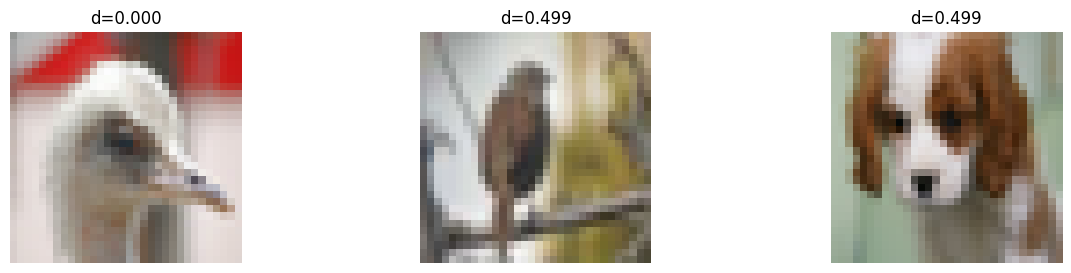

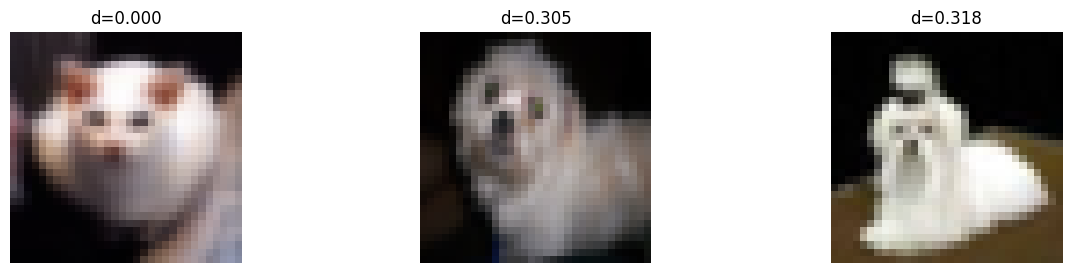

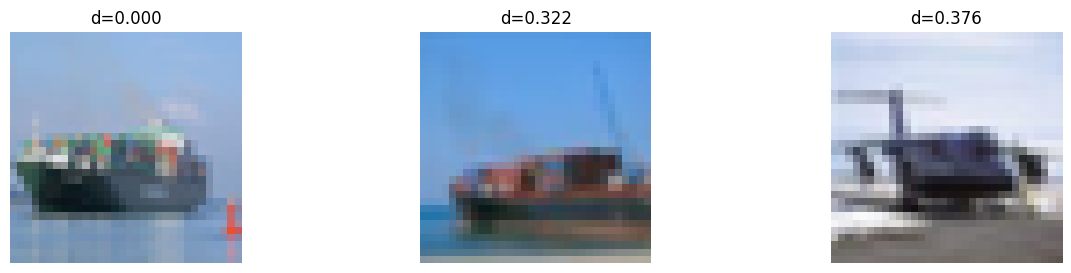

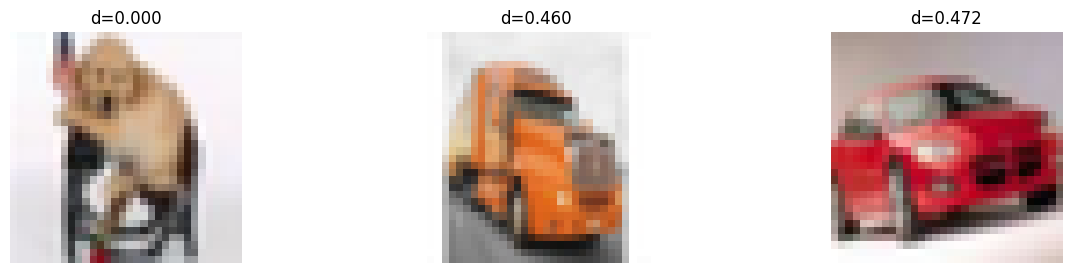

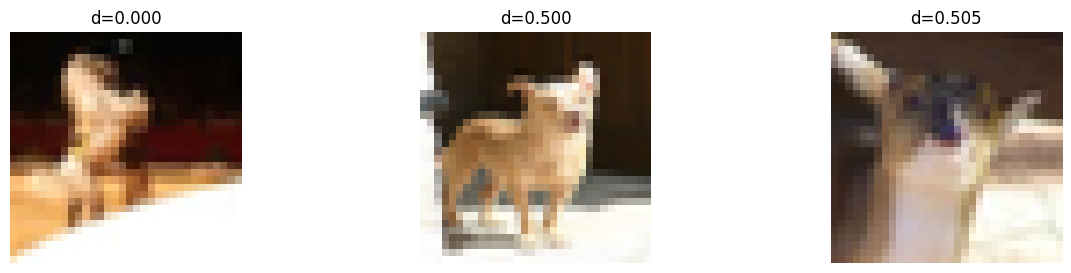

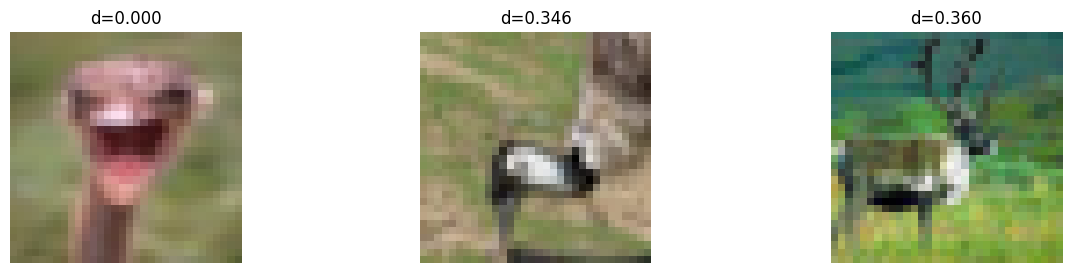

In [19]:
simclr_model.eval() # Enable eval mode for better inference 
embeddings = generate_embeddings(simclr_model, test_simclr_dl)
plot_knn_examples(embeddings, images)

## Fine-tuning SimCLR model

Some hyperparameters

In [20]:
max_epochs = 500

In [13]:
# load model
simclr_model = SimCLRModel()
simclr_model.load_state_dict(torch.load("models/pretrained-simclr-1000.pt"))

<All keys matched successfully>

Early stopping prevents overfitting by stopping the training process once validation loss stops improving.

In [23]:
early_stop_callback = EarlyStopping(
    monitor='val_loss',   
    patience=10,           
    verbose=True,          
    mode='min'             
)

In [24]:
simclr_classifier = Classifier(simclr_model.backbone, num_ftrs=512) # 512 = resnet.fc.in_features
trainer = pl.Trainer(max_epochs=max_epochs, devices=1, accelerator="gpu", log_every_n_steps=1, callbacks=[early_stop_callback])
trainer.fit(simclr_classifier, train_classifier_dl, test_classifier_dl)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | backbone  | Sequential       | 11.2 M
1 | fc        | Linear           | 5.1 K 
2 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
5.1 K     Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 8/8 [00:02<00:00,  3.41it/s, v_num=1, val_loss=2.300, val_acc=0.205]

Metric val_loss improved. New best score: 2.295


Epoch 1: 100%|██████████| 8/8 [00:03<00:00,  2.35it/s, v_num=1, val_loss=2.290, val_acc=0.260]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 2.287


Epoch 2: 100%|██████████| 8/8 [00:03<00:00,  2.31it/s, v_num=1, val_loss=2.280, val_acc=0.293]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 2.279


Epoch 3: 100%|██████████| 8/8 [00:01<00:00,  5.76it/s, v_num=1, val_loss=2.280, val_acc=0.293]

Exception ignored in: <function _releaseLock at 0x7f9ad2718e00>
Traceback (most recent call last):
  File "/home/torstein/anaconda3/envs/tdt05/lib/python3.11/logging/__init__.py", line 237, in _releaseLock
    def _releaseLock():
    
KeyboardInterrupt: 


Epoch 3: 100%|██████████| 8/8 [00:03<00:00,  2.27it/s, v_num=1, val_loss=2.270, val_acc=0.317]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 2.272


Epoch 4: 100%|██████████| 8/8 [00:03<00:00,  2.24it/s, v_num=1, val_loss=2.270, val_acc=0.330]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 2.265


Epoch 5: 100%|██████████| 8/8 [00:01<00:00,  5.51it/s, v_num=1, val_loss=2.270, val_acc=0.330]


Epoch 5: 100%|██████████| 8/8 [00:03<00:00,  2.29it/s, v_num=1, val_loss=2.260, val_acc=0.346]

In [ ]:
torch.save(simclr_classifier.state_dict(), "models/fine-tuned-simclr.cls")

In [15]:
simclr_classifier = Classifier(backbone=simclr_model.backbone, num_ftrs=512)
simclr_classifier.load_state_dict(torch.load("models/fine-tuned-simclr.cls"))

<All keys matched successfully>

In [16]:
simclr_classifier.eval()
eval_classifier(simclr_classifier)

Confusion Matrix:
 [[476  20 135  54  11  24  18  42 169  51]
 [  8 616  14  30  13  21  13  16  57 212]
 [ 90  47 336 105 135  47 122  84  21  13]
 [ 17  70  97 314  65 163 145  78  19  32]
 [ 32  19  85  55 402  37 119 204  17  30]
 [ 12  42  67 225  73 387  63  71  38  22]
 [  3  15  68 100  63  56 676  11   2   6]
 [ 16  18  30  88  72  82  30 593  15  56]
 [102  44  31  48  14  23  14  22 597 105]
 [  7 150   6  53   7  10   1  26  46 694]]

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.48      0.54      1000
           1       0.59      0.62      0.60      1000
           2       0.39      0.34      0.36      1000
           3       0.29      0.31      0.30      1000
           4       0.47      0.40      0.43      1000
           5       0.46      0.39      0.42      1000
           6       0.56      0.68      0.61      1000
           7       0.52      0.59      0.55      1000
           8       0.61      0.60     

## Fine-tuning non-SimCLR model

In [17]:
max_epochs = 500

In [18]:
pretrained_resnet = torchvision.models.resnet18(pretrained=True)

/home/torstein/anaconda3/envs/tdt05/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/torstein/anaconda3/envs/tdt05/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


The early stopping callback needs to be reset to train the other model.

In [19]:
early_stop_callback = EarlyStopping(
    monitor='val_loss',   
    patience=10,           
    verbose=True,          
    mode='min'             
)

In [20]:
pt_classifier = Classifier(pretrained_resnet, num_ftrs=1000) # For some reason, this needs to be 1000 for this model
trainer = pl.Trainer(max_epochs=max_epochs, devices=1, accelerator="gpu", log_every_n_steps=1, callbacks=[early_stop_callback])
trainer.fit(pt_classifier, train_classifier_dl, test_classifier_dl)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2023-11-16 12:15:09.994177: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-16 12:15:10.031706: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-16 12:15:11.205105: W tensor

Epoch 0: 100%|██████████| 8/8 [00:01<00:00,  4.79it/s, v_num=2, val_loss=2.210, val_acc=0.270]

Metric val_loss improved. New best score: 2.211


Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 10.13it/s, v_num=2, val_loss=2.210, val_acc=0.270]

/home/torstein/anaconda3/envs/tdt05/lib/python3.11/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7efe24db56c0>
Traceback (most recent call last):
  File "/home/torstein/anaconda3/envs/tdt05/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/home/torstein/anaconda3/envs/tdt05/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1436, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
                                   ^^^^^^^^^^^^^^^^^^^^
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


In [ ]:
torch.save(pt_classifier.state_dict(), "models/fine-tuned-imagenet.cls")

In [25]:
pt_classifier = Classifier(pretrained_resnet, num_ftrs=1000) # For some reason, this needs to be 1000 for this model
pt_classifier.load_state_dict(torch.load("models/fine-tuned-imagenet.cls"))

<All keys matched successfully>

In [26]:
eval_classifier(pt_classifier)

Confusion Matrix:
 [[384  57 114  71  62  41  41  36 121  73]
 [ 82 301  28 139  50  42  52  44  45 217]
 [143  59 272 135  83  56 123  59  19  51]
 [ 51  68  68 327  75  93 145  76  29  68]
 [ 69  43 192 128 229  52 137  63  20  67]
 [ 33  86  96 247  98 182 107  70  14  67]
 [ 51  56 153 113 105  55 355  29   8  75]
 [ 81  52  96 136 151  84  54 200  16 130]
 [240  94  56  84  87  34  30  51 235  89]
 [ 90 165  33 105  83  34  36  40  60 354]]

Classification Report:
               precision    recall  f1-score   support

           0       0.31      0.38      0.35      1000
           1       0.31      0.30      0.30      1000
           2       0.25      0.27      0.26      1000
           3       0.22      0.33      0.26      1000
           4       0.22      0.23      0.23      1000
           5       0.27      0.18      0.22      1000
           6       0.33      0.35      0.34      1000
           7       0.30      0.20      0.24      1000
           8       0.41      0.23     